In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import files
# uploaded= files.upload()

In [ ]:
#archivo pkl

import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import models,layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix,  precision_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import (OneHotEncoder, label_binarize, LabelEncoder )
import collections
import time
from keras.layers import (Conv1D, MaxPool1D, Dropout, Flatten, Dense,
                          Input, concatenate,Reshape)

from keras.models import Model, Sequential

#cargar archivos dataset (es como dataset mnist)
with open('/content/drive/MyDrive/u/Colab Notebooks/New inteligence/Alerce/Copia de ALERCE_stamps_2020.pkl', 'rb') as f:
    data = pickle.load(f)
# with open('/content/drive/MyDrive/u/Colab Notebooks/New inteligence/Alerce/preproc.txt.npy', 'rb') as g:
#     images_dataset_pre_proc_2 = np.load(g)


In [ ]:
images, labels, metadata = list(data.values())

Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classier

"The alert packet contains three images called stamps, which are cropped at 63 pixels on a side (1 pixel = 1 arcsec) from the original image and centered on the position of the source."

In [ ]:
#convertimos el diccionario a array
images_dataset = np.array(images,dtype=object)
labels_dataset = np.array(labels)
metdat_dataset = np.array(metadata)
data_keys = np.array(list(data))

In [ ]:
#plot distribution metadata
#all images
metadata_keys = ['sgscore1', 'distpsnr1', 'sgscore2', 'distpsnr2', 'sgscore3',
   'distpsnr3', 'isdiffpos', 'fwhm', 'magpsf', 'sigmapsf',
   'ra', 'dec', 'diffmaglim', 'classtar', 'ndethist',
   'ncovhist', 'ecl_lat', 'ecl_long', 'gal_lat', 'gal_long',
   'non_detections', "chinr", "sharpnr"]

In [ ]:
scaler= preprocessing.StandardScaler()

In [ ]:
metadatapd= pd.DataFrame(metdat_dataset,columns=metadata_keys)

In [ ]:
# Define limites speriores e inferiores. Mismo orden que como estan las clases.
upper_limits = [None, None, None, None, None, None, None, 25  , None, None, None, None,  None, None,  200,  2100, None,    None, 
                None,    None,  2100,    None, None]

lower_limits = [-1,   -1,   -1,   -1,   -1,   -1,   None, None, None, None, None, None,  None, None,  None, None, None,   None, 
                None,    None,  None,    -1,   -1]


Queda propuesto modificar outliers por clase, para mejor desempeño.

In [ ]:
metadatapd_limits = metadatapd.copy()
for i in range(len(metadata_keys)):
  metadatapd_limits[metadata_keys[i]].clip(lower=lower_limits[i], upper=upper_limits[i], inplace=True)

In [ ]:
# Se normalizan los datos mediante StandardScaler.
# Entrega array que puede ser util para pasar a tensor y/o para usar en entrenamiento
metadatapd_normalized = scaler.fit_transform(metadatapd_limits)

In [ ]:
metadatapd_normalized_pd = pd.DataFrame(metadatapd_normalized,columns=metadata_keys)

In [ ]:

def center_crop(img, new_width=41, new_height=41):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img


In [ ]:
t_i_preproc= time.time()

scalerMinMax = preprocessing.MinMaxScaler(feature_range=(-1,1))
# tamaño final que se corta la imagen
img_crop = 24 #41
images_dataset_pre_proc_2 = np.zeros((52244,img_crop,img_crop,3))

img_shape = (img_crop,img_crop,3)

# Se normalizan las imagenes y se recortan todos los valores y se transforman los valores nan a 0.

# Se aplica la transformacion a cada canal independiendte
# https://stackoverflow.com/questions/37751717/why-does-minmaxscaler-add-lines-to-image
for i in range(52243):
  images_dataset_pre_proc_2[i] = scalerMinMax.fit_transform(np.array([np.nan_to_num(center_crop(
      images_dataset[i][:,:,0],new_width=img_crop, new_height=img_crop), copy=True, nan=0.0),
      np.nan_to_num(center_crop(images_dataset[i][:,:,1],new_width=img_crop, new_height=img_crop), copy=True, nan=0.0),
      np.nan_to_num(center_crop(images_dataset[i][:,:,2],new_width=img_crop, new_height=img_crop), copy=True, nan=0.0)]
      ).T.reshape(-1,3)).reshape(img_shape)
  
t_f_preproc= time.time()
print(images_dataset_pre_proc_2.shape)
print(f'Tiempo de preprocesamiento: {t_f_preproc-t_i_preproc}[s]')

(52244, 24, 24, 3)
Tiempo de preprocesamiento: 40.39600586891174[s]


In [ ]:
print(images_dataset_pre_proc_2[1].shape)

(24, 24, 3)


In [ ]:
# Se obtienen los sets de entrenamiento, validación y prueba de imagenes
X_train, X_test, y_train, y_test = \
            train_test_split(images_dataset_pre_proc_2, labels_dataset, test_size=0.2, random_state=4106,stratify=labels_dataset)

X_train, X_val, y_train, y_val = \
            train_test_split(X_train, y_train, test_size=0.25, random_state=4106,stratify=y_train) # 0.25 x 0.8 = 0.2

In [ ]:
print(f'Clase 0: {sum(labels_dataset == 0)}. Clase 1: {sum(labels_dataset == 1)}. Clase 2: {sum(labels_dataset == 2)}. Clase 3: {sum(labels_dataset == 3)}. Clase 4: {sum(labels_dataset == 4)}')
print(sum(labels_dataset == 0)+sum(labels_dataset == 1)+sum(labels_dataset == 2)+sum(labels_dataset == 3)+sum(labels_dataset == 4))

Clase 0: 14966. Clase 1: 1620. Clase 2: 14996. Clase 3: 9899. Clase 4: 10763
52244


In [ ]:
print(f'TRAIN: Clase 0: {sum(y_train == 0)}. Clase 1: {sum(y_train == 1)}. Clase 2: {sum(y_train == 2)}. Clase 3: {sum(y_train == 3)}. Clase 4: {sum(y_train == 4)}')
print(sum(y_train == 0)+sum(y_train == 1)+sum(y_train == 2)+sum(y_train == 3)+sum(y_train == 4))

print(f'VALIDATION: Clase 0: {sum(y_val == 0)}. Clase 1: {sum(y_val == 1)}. Clase 2: {sum(y_val == 2)}. Clase 3: {sum(y_val == 3)}. Clase 4: {sum(y_val == 4)}')
print(sum(y_val == 0)+sum(y_val == 1)+sum(y_val == 2)+sum(y_val == 3)+sum(y_val == 4))

print(f'TEST: Clase 0: {sum(y_test == 0)}. Clase 1: {sum(y_test == 1)}. Clase 2: {sum(y_test == 2)}. Clase 3: {sum(y_test == 3)}. Clase 4: {sum(y_test == 4)}')
print(sum(y_test == 0)+sum(y_test == 1)+sum(y_test == 2)+sum(y_test == 3)+sum(y_test == 4))

TRAIN: Clase 0: 8980. Clase 1: 972. Clase 2: 8998. Clase 3: 5939. Clase 4: 6457
31346
VALIDATION: Clase 0: 2993. Clase 1: 324. Clase 2: 2999. Clase 3: 1980. Clase 4: 2153
10449
TEST: Clase 0: 2993. Clase 1: 324. Clase 2: 2999. Clase 3: 1980. Clase 4: 2153
10449


In [ ]:
# Se obtiene array de metadata
data_metadata = np.asarray(metadatapd_limits).astype('float32')
data_umap = False
data_tnse = False
if data_umap:
  reducer = umap.UMAP(n_neighbors=20 , n_components=10, learning_rate=1, min_dist=0.0125, random_state=4106)
  data_metadata = reducer.fit_transform(np.asarray(metadatapd_limits).astype('float32'))
if (not data_umap) and data_tnse:
  t_sne = TSNE(n_components=2, perplexity=30, learning_rate=400, random_state=4106)
  data_metadata = t_sne.fit_transform(np.asarray(metadatapd_limits).astype('float32'))


In [ ]:
# Se obtienen los sets de entrenamiento, validación y prueba de la metadata
X_train_metadata, X_test_metadata, y_train_metadata, y_test_metadata = \
            train_test_split(data_metadata, labels_dataset, test_size=0.2,
                             random_state=4106, stratify=labels_dataset)

X_train_metadata, X_val_metadata, y_train_metadata, y_val_metadata = \
            train_test_split(X_train_metadata, y_train_metadata, test_size=0.25, random_state=4106, stratify=y_train_metadata) # 0.25 x 0.8 = 0.2

In [ ]:
assert (y_train == y_train_metadata).all
assert (y_val == y_val_metadata).all
assert (y_test == y_test_metadata).all

In [ ]:
# Se escala los metadatos
X_train_metadata = scaler.fit_transform(X_train_metadata)
X_val_metadata = scaler.transform(X_val_metadata)
X_test_metadata = scaler.transform(X_test_metadata)

In [ ]:
#Numero de objetos por clase en se de train y de entrenamiento
#Clase 0: 14966. Clase 1: 1620. Clase 2: 14996. Clase 3: 9899. Clase 4: 10763
#Train
#Clase 0: 8980. Clase 1: 972. Clase 2: 8998. Clase 3: 5939. Clase 4: 6457

n = [1, 6100, 1, 1000, 600] # imagenes nueva por clase
c = [0, 1, 2, 3, 4] # Clases que se quiere aumenta 
n_c = [8980, 972, 8998, 5939, 6457]  # Cantidad de valores en el set de entrenamiento para obtener valores random

np.random.seed(4106)
# indices aleatorios
i_samples = []
for i, n_i in enumerate(n):
  i_samples.append(np.random.randint(n_c[i], size=n_i) ) # se obtienen numeros aleatorios para sampling del set de entrenamiento

# se definen las capas de data augmentation
height_factor = (0.06,0.06)
width_factor = (0.06,0.06)
data_augmentation = tf.keras.Sequential([layers.RandomRotation(0.8),tf.keras.layers.RandomTranslation(
    height_factor, width_factor, fill_mode='nearest' )])
# height_factor = (0.6,0.6)
# width_factor = (0.6,0.6)
# data_augmentation_2 = tf.keras.Sequential([layers.RandomRotation(0.8),tf.keras.layers.RandomTranslation(
#     height_factor, width_factor, fill_mode='nearest' )])

plot_images = False
# Recorre cada clase.
# Obtiene el numero de muestras que se desea por clase
for j, c_i in enumerate(c):

  for i in i_samples[j]:
    # Se obtiene imagen segun numero aleatorio
    img_sample = X_train[y_train == c_i][i]
    # Se obtiene los metadatos asociados a esa imagen (solo se copian)
    md_sample = X_train_metadata[y_train == c_i][i]
    # Se obtiene la nueva imagen
    augmented_image = data_augmentation(img_sample)

    # Se agrega nueva imagen al test de train
    X_train = np.append(X_train,
                        tf.reshape(augmented_image,(1,augmented_image.shape[0],augmented_image.shape[1],augmented_image.shape[2])),
                        axis=0)
    # Se agrega metadatos asociaos a la imagen
    X_train_metadata = np.append(X_train_metadata, md_sample.reshape(1,md_sample.shape[0]),axis=0)

    # Se agrega clase asociada
    y_train = np.append(y_train, c_i)

    # Para visualizar rotacion descomentar
    if plot_images:
      fig, axs = plt.subplots(3,3,figsize=(15,15))
      color =  'magma'
      first_image_1 = img_sample[:,:,0]
      second_image_1 = img_sample[:,:,1]
      third_image_1 = img_sample[:,:,2]
      pixels_1= [first_image_1.reshape((img_crop, img_crop)), second_image_1.reshape((img_crop,img_crop)), third_image_1.reshape((img_crop, img_crop))]
      axs[0,0].imshow(pixels_1[0],cmap=color)
      axs[0,1].imshow(pixels_1[1],cmap=color)
      axs[0,2].imshow(pixels_1[2],cmap=color)

      first_image = augmented_image[:,:,0]
      second_image = augmented_image[:,:,1]
      third_image = augmented_image[:,:,2]
      pixels= [first_image, second_image, third_image]
      axs[1,0].imshow(pixels[0],cmap=color)
      axs[1,1].imshow(pixels[1],cmap=color)
      axs[1,2].imshow(pixels[2],cmap=color)

      augmented_image_2 = data_augmentation_2(img_sample)
      first_image_2 = augmented_image_2[:,:,0]
      second_image_2 = augmented_image_2[:,:,1]
      third_image_2 = augmented_image_2[:,:,2]
      pixels_2 = [first_image_2, second_image_2, third_image_2]
      axs[2,0].imshow(pixels_2[0],cmap=color)
      axs[2,1].imshow(pixels_2[1],cmap=color)
      axs[2,2].imshow(pixels_2[2],cmap=color)
    

# Se revuelven los datos de entrenamiento
# es el mismo shuffle para X_train, X_train_metadata, y_train
shuffler = np.random.permutation(X_train.shape[0])

X_train = X_train[shuffler]
X_train_metadata = X_train_metadata[shuffler]
y_train = y_train[shuffler]

In [ ]:
# Se define el modelo

model2 = False

# Input imagenes
sequence = Input(shape=(img_crop, img_crop, 3), name='Sequence')
# Input metadata
features = Input(shape=(23,), name='Features')

# Se define red convolucional de cyclic pooling
model = models.Sequential()
model.add(layers.ZeroPadding2D(padding=1,input_shape=(img_crop,img_crop,3)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))#, input_shape=(41, 41, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# Se aplica la red para cada rotacion
part1 = model(sequence)
part2 = model(tf.image.rot90(sequence, k=1))
part3 = model(tf.image.rot90(sequence, k=2))
part4 = model(tf.image.rot90(sequence, k=3))

# Se obtiene cyclic pooling
cyclic_pooling = tf.keras.layers.Average()([part1,part2,part3,part4])
 
# Capas densas después de cyclic pooling

if model2:
  cyclic_pooling = layers.Dense(128, activation='relu')(cyclic_pooling)
  cyclic_pooling = layers.Dense(64, activation='relu')(part_cypool)

# Batch normalization para metadatos
part_md = layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(features)

# Se concatenan salida de cyclic pooling con metadatos 
merged = concatenate([cyclic_pooling, part_md])

# Se palica capas finales
final= Dense(64, activation='relu')(merged)
final= Dropout(0.5)(final)
final= Dense(64, activation='relu')(final)
# Se aplica capa final de salida
final= Dense(units= 5, activation='softmax')(final)

# Se define modelo final con las respectivas entradas
model = models.Model(inputs=[sequence, features], outputs=[final])

# Modelo auxiliar con salida el cyclic pooling
model_aux = models.Model(inputs=[sequence], outputs=[cyclic_pooling])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence (InputLayer)          [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 tf.image.rot90 (TFOpLambda)    (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_1 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_2 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                              

In [ ]:
model_aux.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence (InputLayer)          [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 tf.image.rot90 (TFOpLambda)    (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_1 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_2 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                            

In [ ]:
# Se define early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:

def Entropy_Regularization(y_true,y_pred):
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  cross_entropy = loss(y_true=y_true, y_pred=y_pred)
  
  loss_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
  regul = loss_2(y_true=y_pred, y_pred=y_pred)

  Loss = cross_entropy - 0.5*regul
  return Loss

In [ ]:
# Se define funcion Loss y optimizador
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.5, beta_2=0.9,amsgrad=True,name='Adam')
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# loss_model = Entropy_Regularization

model.compile(optimizer=opt,
             loss=loss_model,
             metrics=['accuracy'])


In [ ]:
# Se definen pesos para introducir a la red
# Clase 0: 14966. Clase 1: 1620. Clase 2: 14996. Clase 3: 9899. Clase 4: 10763
c_0, c_1, c_2, c_3, c_4 = 14966, 1620, 14996, 9899, 10763
n = 14966 + 1620 + 14996 + 9899 + 10763
w_0, w_1, w_2, w_3, w_4 = 10000*n/c_0**2, 1000000*n/c_1**2, 10000*n/c_2**2, 100000*n/c_3**2, 100000*n/c_4**2
class_weight = {0: w_0,
                1: w_1,
                2: w_2,
                3: w_3,
                4: w_4}

print( w_0, w_1, w_2, w_3, w_4 )

In [ ]:
run_n_times = 1
stats_history = []
for run in range(run_n_times):

  loss_cp_tr = [0] #historial de loss, 50 epocas
  loss_cp_val = [0]
  loss_plot_tr=[] #historial de loss para plot
  loss_plot_val=[]
  accuracy_plot_tr=[]
  accuracy_plot_val=[]
  recall_plot_tr=[]
  recall_plot_val=[]
  precision_plot_tr=[]
  precision_plot_val=[]
  f1score_plot_tr=[]
  f1score_plot_val=[]
  t_i_train=time.time()

  tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
  #history = model.fit(X_train, y_train,batch_size = 64, epochs=50, callbacks=[tb_callback], validation_data=(X_val, y_val))
  history = model.fit([X_train,X_train_metadata], y_train,batch_size = 32, epochs=50, callbacks=[callback], 
                      validation_data=([X_val,X_val_metadata], y_val), )#class_weight=class_weight)
          
  stats_history.append(history)

  loss_plot_tr.append(history.history['loss'])
  loss_plot_val.append(history.history['val_loss'])
  accuracy_plot_tr.append(history.history['accuracy'])
  accuracy_plot_val.append(history.history['val_accuracy'])
      
t_f_train=time.time()
print('\nEntrenamiento finalizado')
print(f'Tiempo de entrenamiento: {t_f_train-t_i_train}[s]')

Epoch 1/50
1221/1221 [==============================] - 53s 35ms/step - loss: 0.5565 - accuracy: 0.8019 - val_loss: 0.3098 - val_accuracy: 0.8986
Epoch 2/50
1221/1221 [==============================] - 41s 34ms/step - loss: 0.3310 - accuracy: 0.8864 - val_loss: 0.2433 - val_accuracy: 0.9176
Epoch 3/50
1221/1221 [==============================] - 41s 34ms/step - loss: 0.2965 - accuracy: 0.8986 - val_loss: 0.2293 - val_accuracy: 0.9210
Epoch 4/50
1221/1221 [==============================] - 41s 34ms/step - loss: 0.2733 - accuracy: 0.9079 - val_loss: 0.2205 - val_accuracy: 0.9235
Epoch 5/50
1221/1221 [==============================] - 42s 34ms/step - loss: 0.2615 - accuracy: 0.9096 - val_loss: 0.2081 - val_accuracy: 0.9291
Epoch 6/50
1221/1221 [==============================] - 41s 34ms/step - loss: 0.2519 - accuracy: 0.9147 - val_loss: 0.1996 - val_accuracy: 0.9337
Epoch 7/50
1221/1221 [==============================] - 42s 34ms/step - loss: 0.2386 - accuracy: 0.9172 - val_loss: 0.2040 -

In [ ]:
train_acc_history = np.array([run.history['accuracy'][-1] for run in stats_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

val_acc_history = np.array([run.history['val_accuracy'][-1] for run in stats_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

Train accuracy 0.948 +/- 0.000
[0.94783342]
Validation accuracy 0.936 +/- 0.000
[0.93587905]


In [ ]:
model_aux.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence (InputLayer)          [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 tf.image.rot90 (TFOpLambda)    (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_1 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                                  
 tf.image.rot90_2 (TFOpLambda)  (None, 24, 24, 3)    0           ['Sequence[0][0]']               
                                                                                            

In [ ]:
# model.save('/content/drive/MyDrive/u/Colab Notebooks/New inteligence/Alerce/modelo6')

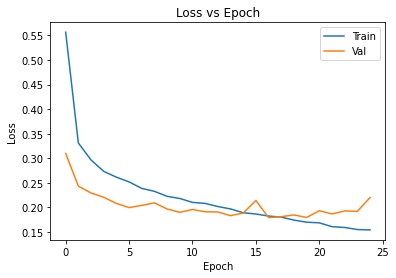

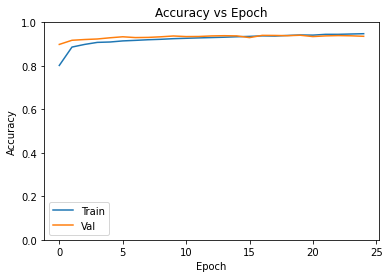

In [ ]:
import matplotlib.pyplot as plt
def plot_history():
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch')
  plt.plot(np.arange(len(loss_plot_tr[0])), loss_plot_tr[0], 
           label='Train')
  plt.plot(np.arange(len(loss_plot_val[0])), loss_plot_val[0],
           label = 'Val')
  plt.legend()
  #plt.ylim([0,1])

def plot_accuracy():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.plot(np.arange(len(accuracy_plot_tr[0])), accuracy_plot_tr[0], 
            label='Train')
    plt.plot(np.arange(len(accuracy_plot_val[0])), accuracy_plot_val[0],
            label = 'Val')
    plt.legend()
    plt.ylim([0,1])

plot_history()
plot_accuracy()

In [ ]:
# Cantidad de clases en set de validacion
collections.Counter(y_val)

Counter({0: 2993, 1: 324, 2: 2999, 3: 1980, 4: 2153})

In [ ]:
results=model.evaluate((X_test,X_test_metadata),y_test)
print(f'Loss Test = {results[0]}, Accuracy Test{results[1]}')

327/327 [==============================] - 4s 13ms/step - loss: 0.2073 - accuracy: 0.9384


[0.20734375715255737, 0.9383673071861267]

In [ ]:
predictions = model.predict((X_test,X_test_metadata),)
predictions_classes = np.argmax(predictions, axis=1)
predictions_classes.shape

(10449,)

In [ ]:
y_test.shape

(10449,)

In [ ]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(predictions_classes,y_test)
print(acc.result().numpy())

0.9383673


In [ ]:
# Metricas por Clase
matrix = confusion_matrix(y_test, predictions_classes)
acc = matrix.diagonal()/matrix.sum(axis=1)
# acc = accuracy_score(y_test, predictions_classes)
precision, recall, f1, _ = score(y_test, predictions_classes)

print('accuracy: {} , promedio accuracy {}'.format(acc,np.mean(acc)))
print('precision: {}, promedio precision {}'.format(precision,np.mean(precision)))
print('recall: {}, promedio recall {}'.format(recall,np.mean(recall)))
print('fscore: {}, promedio fscore {}'.format(f1,np.mean(f1)))

accuracy: [0.93351153 0.78703704 0.9333111  0.99090909 0.92661403] , promedio accuracy 0.9142765570965216
precision: [0.94010767 0.77981651 0.94179004 0.92155942 0.97364568], promedio precision 0.9113838648253557
recall: [0.93351153 0.78703704 0.9333111  0.99090909 0.92661403], promedio recall 0.9142765570965216
fscore: [0.93679799 0.78341014 0.9375314  0.95497688 0.94954783], promedio fscore 0.9124528485346062


In [ ]:
pred=[]
for elemento in predictions:
  pred.append(np.where(elemento==elemento.max())[0][0])

In [ ]:
confmatr=tf.math.confusion_matrix(y_test, pred)
confmatr

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[2794,   28,  146,    5,   20],
       [   8,  255,    1,   53,    7],
       [ 157,    8, 2799,   16,   19],
       [   1,    6,    3, 1962,    8],
       [  12,   30,   23,   93, 1995]], dtype=int32)>

In [ ]:
# Matriz de Confusion


def custom_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          plot_size = None,
                          cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        normalize_factor = cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / normalize_factor
        cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        cm = np.floor(cm).astype('int')

    fig, ax = plt.subplots(figsize=plot_size,  dpi=80)
    if normalize:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin= np.min(cm), vmax= np.max(cm))
    else:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() - cm.min() ) / 2.  + cm.min()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):

            ax.text(j, i, format(cm[i, j], fmt) + r'$\%$' ,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax, fig

Normalized confusion matrix


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff98972cb10>,
 <Figure size 544x544 with 2 Axes>)

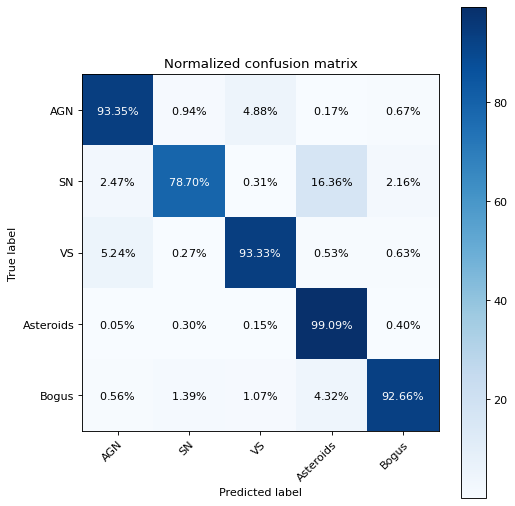

In [ ]:
custom_confusion_matrix(y_test, predictions_classes,np.array(['AGN','SN','VS','Asteroids','Bogus']),normalize=True,plot_size = (6.8,6.8))

In [ ]:
LOG_DIR = './logs'
print("Showing summaries at %s" % (LOG_DIR))

%load_ext tensorboard
%tensorboard --logdir='$LOG_DIR'

Showing summaries at ./logs


<IPython.core.display.Javascript object>

- Juntar dataset imagenes y labels
- Hacerle shuffle y separar en train, valid, test
- Oversampling y Data Augmentation 
- Terminar pre-procesamiento metadata (outliers)
- Agregar metadata a la red
- Probar clasificación 5 clases vs Binaria
- Probar red de los papers, y otras famosas vista en clase